**REPLICATION CODE: MOURIFIÉ/HENRY/MEANGO**

Start date: 26/10/2025
Author: Jordi Torres Vallverdú

Goal: idea is to replicate the analysis done by Mourifié et al (2020) in another context with another data. The idea is to seek new applications of their methodology.

Notes on the context: I am using data on Belgium region of Flandes in the 1990s. I have a panel of students observed from the beginning of high-school up to two years into higher education. Given that I don't observe future labor outcomes, I will only consider potential outcomes in terms of success probability of having completed the first year of higher education (this is a proxy for completion)


$D=\{1,0\}$, where 1 is entered stem high school track and 0 if entered non-stem high-school track

$Y=\{1,0\}$, where 1 is graduated from stem degree and 0 is graduated from non-stem degree

Z, set of instruments


**1. Data manipulation**

In [1]:
using StatFiles, DataFrames

#Input path
data_path = "/Users/jorditorresvallverdu/Library/Mobile Documents/com~apple~CloudDocs/tse/year1/papers_final_memoire/data/clean/roymodel_database.dta" ##-->CHANGE JUST THIS PART MANUALLY!

#Output path
export_dir = "/Users/jorditorresvallverdu/Documents/GitHub/TSE-2025-2026/set_identification/" ##Change this manually too


main = DataFrame(load(data_path))

Row,ID,hs_course1,hs_stem1,postsec_type2,postsec_stem2,c_par_income,c_par_spokenlanguage_dutch_fa,c_par_dialect_fa,c_par_spokenlanguage_dutch_mo,c_par_dialect_mo,c_iq_male,c_iq_birth_year,c_iq_birth_month,c_iq_NIQ,c_iq_VIQ,c_iq_SIQ,c_iq_IQ,c_iq_opl,c_sskills_workparents,c_sskills_income,c_sskills_IQ_discrete,z_numeric_iq,income_reduced
,Int32?,Float32?,Float32?,Float32?,Float32?,Int32?,Float32?,Float32?,Float32?,Float32?,Int8?,Int16?,Int8?,Float32?,Float32?,Float32?,Float32?,Int8?,Float32?,Float32?,Float32?,Int8?,Float32?
1,11135,6.0,1.0,2.0,0.0,4,1.0,0.0,1.0,0.0,1,1978,8,91.4869,120.331,109.205,110.171,2,1.0,3.0,5.0,1,2.0
2,11137,6.0,0.0,1.0,0.0,5,1.0,1.0,1.0,0.0,0,1978,10,97.4658,107.186,100.036,102.72,1,1.0,4.0,4.0,2,3.0
3,11154,6.0,1.0,1.0,0.0,missing,missing,missing,missing,missing,1,1978,5,106.991,115.378,104.474,111.563,2,missing,1.0,5.0,3,1.0
4,11161,6.0,1.0,1.0,1.0,5,1.0,0.0,1.0,0.0,0,1978,2,110.288,115.582,99.4507,111.189,3,1.0,4.0,5.0,4,3.0
5,11162,6.0,1.0,1.0,0.0,4,1.0,0.0,1.0,0.0,0,1978,2,118.363,100.334,90.7207,103.559,1,1.0,3.0,4.0,6,2.0
6,11163,6.0,1.0,2.0,0.0,5,1.0,0.0,1.0,0.0,0,1978,6,120.458,118.775,126.786,125.161,3,1.0,4.0,6.0,6,3.0
7,11166,6.0,1.0,2.0,0.0,missing,1.0,0.0,1.0,0.0,0,1978,11,95.3408,91.9245,89.5506,90.9654,3,missing,1.0,3.0,1,1.0
8,11171,6.0,0.0,1.0,0.0,4,1.0,0.0,1.0,0.0,0,1978,5,110.01,125.206,121.763,123.113,2,1.0,3.0,6.0,4,2.0
9,11172,6.0,1.0,2.0,1.0,missing,missing,missing,missing,missing,1,1978,10,108.808,96.97,99.3044,101.327,3,missing,1.0,4.0,4,1.0



First we create a subsample of observations on gender and socio-economic status, just like they do in their exercise. I will create bins based on this: 

- Gender
- Income categories: 5 brackets
- Minority status (proxied by family background)?


In [2]:
using DataFramesMeta, Statistics 

groups = groupby(main, [:c_sskills_income, :c_iq_male])
subsamples = [DataFrame(g) for g in groups]



10-element Vector{DataFrame}:
 305×23 DataFrame
 Row │ ID      hs_course1  hs_stem1  postsec_type2  postsec_stem2  c_par_incom ⋯
     │ Int32?  Float32?    Float32?  Float32?       Float32?       Int32?      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  11166         6.0       1.0            2.0            0.0       missin ⋯
   2 │  11246         6.0       0.0            1.0            0.0       missin
   3 │  11272         6.0       1.0            2.0            0.0       missin
   4 │  11311         6.0       1.0            2.0            0.0
   5 │  11457         6.0       0.0            2.0            0.0       missin ⋯
   6 │  11473         6.0       0.0            2.0            0.0       missin
   7 │  12652         6.0       0.0            2.0            1.0       missin
   8 │  12666         4.0       0.0            2.0            0.0       missin
  ⋮  │   ⋮         ⋮          ⋮            ⋮              ⋮             ⋮      ⋱
 299 

**2. Estimating bounds on the L(z) measure**

The goal is now to understand what explains the violations of Roy selection model using the same method as in Mourifié, Henry, Meango (2020). Will keep the same example going, but, if needed, I will also include a continuous instrument: example can be numeric IQ estimated at baseline. 

The main issue with this literature is that sample analogs of $\Theta_I$ are the suprema and infima of estimated bounding functions and they have substantial finite sample bias and estimated bounds tend to be much tighter than population bounds. -->Manski/Pepper (2001).

Chernozukov, Lee and Rosen (2013) propose a method to deal with this, which I replicate in Julia. 

**2.1. Z discrete: Parental Education**

In [3]:
using DataFrames, Statistics

#this estimate probabilities in a simple manner

function cell_probs_0(df::DataFrame, instrument::Symbol, yvar::Symbol)

    zvals = sort(unique(df[!, instrument]))
    k = length(zvals)
    n = nrow(df)

    beta_hat = Vector{Float64}(undef, k)   
    n_k      = Vector{Int}(undef, k)      

    for (j, z) in enumerate(zvals) #j is position and z is value in position j of a vector
        idx = df[!, instrument] .== z
        nj = count(idx)
        n_k[j] = nj

        if nj == 0
            beta_hat[j] = NaN
        else
            beta_hat[j] = mean(df[idx, yvar] .== 0)
        end
    end

    return zvals, beta_hat, n_k, n, k
end


cell_probs_0 (generic function with 1 method)

In [4]:

#to try:
zvals, beta_hat, n_k, n, k = cell_probs_0(subsamples[1], :c_iq_opl, :postsec_stem2)


(Union{Missing, Int8}[1, 2, 3], [0.75, 0.6261682242990654, 0.5444444444444444], [108, 107, 90], 305, 3)

In [5]:
#3.Estimate asymptotic variance, simple

using LinearAlgebra

function variance_compute(beta_hat::Vector{Float64}, n_k::Vector{Int}, n::Int)
    k = length(beta_hat)
    Ωdiag = zeros(Float64, k)

    for j in 1:k
         if n_k[j] == 0 || isnan(beta_hat[j])
            Ωdiag[j] = NaN

         else 
        Ωdiag[j] = n * beta_hat[j] * (1.0 - beta_hat[j]) / n_k[j]
         end 
    end
    Ω = Diagonal(Ωdiag)
    sqrt_Ω= Diagonal(sqrt.(Ωdiag))
    return Ω, sqrt_Ω
end


variance_compute (generic function with 1 method)

In [6]:
Ω, Ω_sqrt=variance_compute(beta_hat, n_k, n)

([0.5295138888888888 0.0 0.0; 0.0 0.6672418845705824 0.0; 0.0 0.0 0.840528120713306], [0.7276770498572075 0.0 0.0; 0.0 0.8168487525671949 0.0; 0.0 0.0 0.9168032071896923])

In [7]:

#4. Define momments
function define_moments_for_j(beta_hat::Vector{Float64}, j::Int)
    k = length(beta_hat)

    V = collect(1:j-1)         
    M = length(V)

    p_list = Vector{Vector{Float64}}(undef, M)
    theta_hat = Vector{Float64}(undef, M)

    for (m, i) in enumerate(V)
        p = zeros(Float64, k)
        p[j] =  1.0 
        p[i] = -1.0
        p_list[m] = p

        theta_hat[m] = beta_hat[j] - beta_hat[i]
    end

    return V, p_list, theta_hat
end


define_moments_for_j (generic function with 1 method)

In [8]:
#step 5-> g_hats, s_n, simply follow their rules

using LinearAlgebra

function compute_g_and_s(p_list::Vector{Vector{Float64}}, Ω_sqrt::Diagonal, n::Int)
    M= length(p_list)
    k=length(p_list[1])

    g_hats = Vector{Vector{Float64}}(undef, M)
    s_n    = Vector{Float64}(undef, M)

    for m in 1:M
        g_hats[m]= vec(p_list[m]'*Ω_sqrt)
        s_n[m] = norm(g_hats[m]) / sqrt(n)
    end 

    return g_hats, s_n
end



compute_g_and_s (generic function with 1 method)

In [9]:
#step 6-->this function should be generalizable for first step critical value and second step critical value. 

using LinearAlgebra, Statistics

function clr_critical_value(g_hats::Vector{Vector{Float64}}, R::Int, n::Int, critic::Float64; rng=Random.default_rng())

    M = length(g_hats)           
    K = length(g_hats[1])        

    T = zeros(Float64, R)

    for r in 1:R
        Zr = randn(rng, K)

        best = -Inf
        vals = zeros(M)
        for m in 1:M
            g = g_hats[m]
            val = dot(g, Zr) / norm(g)

            if val>best 
                best=val
            end    
        end

        T[r] = best
    end

    k_nV = quantile(T, critic)

    return k_nV
end


clr_critical_value (generic function with 1 method)

In [10]:

#step 7->this restricts the number of moments taking into account those that are close to binding. 

function restrict_moments(theta_hat::Vector{Float64}, k_nV::Float64, s_n::Vector{Float64})

    M = length(theta_hat)
    B = similar(theta_hat)

    for m in 1:M
        B[m] = theta_hat[m] + k_nV * s_n[m]
    end
    
    b = minimum(B)

    V_hat_idx = Int[]

    for m in 1:M
        if theta_hat[m] <= b + 2 * k_nV * s_n[m]
            push!(V_hat_idx, m)
        end
    end

    return V_hat_idx
end


restrict_moments (generic function with 1 method)

In [11]:
function clr_lower_bound(theta_hat, s_n, k_nVhat)
    minimum(theta_hat .+ k_nVhat .* s_n)
end
#useless when we loop for j. archive

clr_lower_bound (generic function with 1 method)

In [12]:
function clr_lower_bound_for_j(theta_hat, s_n, k_nVhat, Vhat)

    return minimum(theta_hat[m] .+ k_nVhat .* s_n[m] for m in Vhat)

end 

clr_lower_bound_for_j (generic function with 1 method)

In [13]:

#FINAL STEP: this function calls all the others in order.


function clr_el_discrete(df::DataFrame, Z::Symbol, Y::Symbol; R=2000, rng=Random.default_rng())
    zvals, beta_hat, n_k, n, k = cell_probs_0(df, Z, Y)
    _, Ωsqrt = variance_compute(beta_hat, n_k, n)

    el_L = fill(NaN, k)
    el_L[1] = 0.0 #by default, first point in discrete case will be 0

    for j in 2:k
        V, p_list, theta_hat = define_moments_for_j(beta_hat, j)
        g_hats, s_n = compute_g_and_s(p_list, Ωsqrt, n)

        γ_n = 1 - 0.1 / log(n)


        k_nV = clr_critical_value(g_hats, R, n,γ_n; rng )
        Vhat = restrict_moments(theta_hat, k_nV, s_n)

        g_hats_Vhat = g_hats[Vhat]

        k_nV_2 = clr_critical_value(g_hats_Vhat, R, n, 0.90; rng) #I assume 90% confidence level as MHM. 


        el_L[j] = minimum(theta_hat[m] + k_nV_2*s_n[m] for m in Vhat)
    end

    return zvals, beta_hat, el_L
end


clr_el_discrete (generic function with 1 method)

In [14]:

#Final step: apply the function, R=1000, 90% confidence lvel, and a seed for reproducibility. I apply it for each subsample. Note that here I manually specify c_iq_opl=education level, postsec_stem2=0,1 if Stem in university.
#The function is generable and other Y and Z can be used -if both discrete-.

using Random
Random.seed!(12345)

N= length(subsamples)

results= [clr_el_discrete(i, :c_iq_opl, :postsec_stem2; R=2000, rng=Random.default_rng()) for i in subsamples]


10-element Vector{Tuple{Vector{Union{Missing, Int8}}, Vector{Float64}, Vector{Float64}}}:
 ([1, 2, 3], [0.75, 0.6261682242990654, 0.5444444444444444], [0.0, -0.04113108012749392, -0.10691972480558283])
 ([1, 2, 3], [0.4691358024691358, 0.4050632911392405, 0.4485981308411215], [0.0, 0.03398845071892963, 0.09936029963159974])
 ([1, 2, 3], [0.7886178861788617, 0.7101449275362319, 0.6052631578947368], [0.0, 0.008229530845045768, -0.059996852608450085])
 ([1, 2, 3], [0.390625, 0.4473684210526316, 0.2631578947368421], [0.0, 0.1929979621579868, 0.01652756062689889])
 ([1, 2, 3], [0.7567567567567568, 0.6428571428571429, 0.7261904761904762], [0.0, -0.028152546817280577, 0.0797084712777482])
 ([1, 2, 3], [0.40350877192982454, 0.4507042253521127, 0.3148148148148148], [0.0, 0.16326669318015985, -0.0017411719349643973])
 ([1, 2, 3], [0.7222222222222222, 0.6515151515151515, 0.6938775510204082], [0.0, 0.08755291534595272, 0.1579798241989744])
 ([1, 2, 3], [0.42857142857142855, 0.4782608695652174, 0.4

In [15]:

#plot the results!! by subsample.
zgrid = results[1][1]   # [1,2,3]
G = length(zgrid)
B = length(results) ÷ 2

el_women = zeros(G, B)
el_men   = zeros(G, B)

for b in 1:B
    el_women[:, b] .= max.(results[2*b - 1][3], 0.0)
    el_men[:, b]   .= max.(results[2*b][3], 0.0)
end


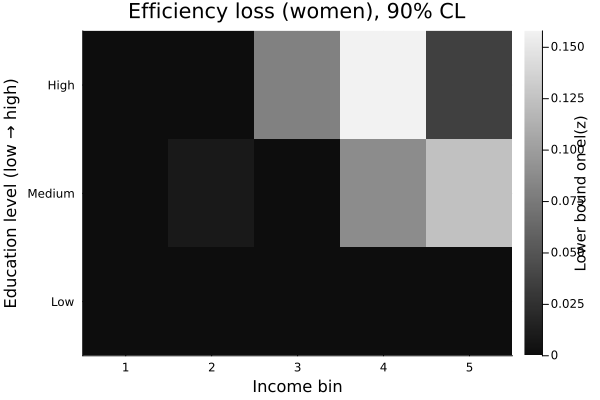

In [16]:
using Plots

pdiscrete=heatmap(
    1:B,
    1:G,
    el_women;
    xlabel = "Income bin",
    ylabel = "Education level (low → high)",
    yticks = (1:G, ["Low", "Medium", "High"]),
    title  = "Efficiency loss (women), 90% CL",
    color  = :grays,
    clims  = (0, maximum(el_women)),
    colorbar_title = "Lower bound on el(z)"
)


In [17]:
savefig(pdiscrete, joinpath(export_dir, "efficiency_loss_women_discrete.png"))


"/Users/jorditorresvallverdu/Documents/GitHub/TSE-2025-2026/set_identification/efficiency_loss_women_discrete.png"

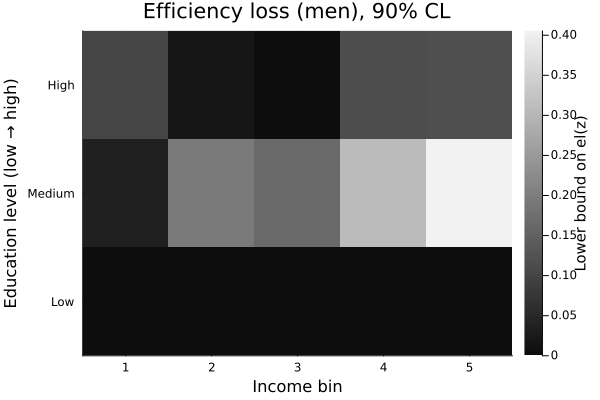

In [18]:
using Plots

pdiscrete=heatmap(
    1:B,
    1:G,
    el_men;
    xlabel = "Income bin",
    ylabel = "Education level (low → high)",
    yticks = (1:G, ["Low", "Medium", "High"]),
    title  = "Efficiency loss (men), 90% CL",
    color  = :grays,
    clims  = (0, maximum(el_men)),
    colorbar_title = "Lower bound on el(z)"
)

In [19]:
savefig(pdiscrete, joinpath(export_dir, "efficiency_loss_men_discrete.png"))


"/Users/jorditorresvallverdu/Documents/GitHub/TSE-2025-2026/set_identification/efficiency_loss_men_discrete.png"

**CASE WHERE Z IS CONTINUOUS**

In [20]:
using StatsBase, CategoricalArrays

#Functions used throughout

#This is because of numerical issues:
function rescale_to_unit(z::Vector{Float64})
    zmin, zmax = minimum(z), maximum(z)
    ztilde = (z .- zmin) ./ (zmax - zmin)  
    return ztilde, zmin, zmax
end

#Flexible function that I can use with choosen number of polynomials K.
function poly_basis(z::Vector{Float64}, K::Int)
    n = length(z)
    P = Matrix{Float64}(undef, n, K)
    for k in 1:K
        P[:, k] .= z .^ (k - 1)
    end
    return P
end





poly_basis (generic function with 1 method)

In [21]:
###Same step 1, but let's allow for Z to be continuous. This is a full replication of CLR algorithm in page 708-709 of Chernozhukov, Lee, Rosen ECTA 2013 paper.

using DataFrames, Statistics, LinearAlgebra

function cell_probs_0_continuous(df::DataFrame, instrument::Symbol, yvar::Symbol, Order::Int, G::Int)

    z_raw= Float64.(df[!,instrument]) #returns vector nx1
    

    z_rescale, zmin, zmax= rescale_to_unit(z_raw) #rescales vector to lie between 0-1->numerical reasons
    P= poly_basis(z_rescale,Order) #computes nxk basis


    Y_0= Float64.(df[!,yvar].==0) #returns vector nx1
    n=length(Y_0)


    beta_hat= (P'*P)\(P'*Y_0) #k*1 betas

    #project discretized bins!

    zgrid_unit = range(0.0, 1.0; length = G)
    zgrid = zmin .+ zgrid_unit .* (zmax - zmin)     

    Pgrid = poly_basis(collect(zgrid_unit), Order)      #G×K

    theta_hat_grid = Pgrid * beta_hat                   #G*1

    G= length(zgrid)



    return theta_hat_grid, Pgrid, zgrid, Y_0, beta_hat, P, G, n
end

cell_probs_0_continuous (generic function with 1 method)

In [22]:
theta_hat_grid, Pgrid, zgrid, Y_0, beta_hat, P, G, n =cell_probs_0_continuous(subsamples[1], :c_iq_NIQ, :postsec_stem2, 4, 100)

#it works

([1.0357828706943852, 1.0155649960248276, 0.9961364968582155, 0.9774805820580483, 0.9595804604878259, 0.9424193410110474, 0.9259804324912126, 0.910246943791821, 0.8952020837763719, 0.8808290613083651  …  0.40500032365512645, 0.3885777425662603, 0.37143333469529727, 0.3535503089057361, 0.33491187406107675, 0.3155012390248189, 0.2953016126604614, 0.2742962038315048, 0.25246822140144753, 0.2298008742337898], [1.0 0.0 0.0 0.0; 1.0 0.010101010101010102 0.0001020304050607081 1.0306101521283648e-6; … ; 1.0 0.98989898989899 0.9799000102030406 0.9700020303019998; 1.0 1.0 1.0 1.0], 74.16575622558594:0.6005239775686553:133.6176300048828, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0  …  0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [1.0357828706943852, -2.041197787186528, 3.9506196166051293, -2.715403825879197], [1.0 0.3561719022297919 0.12685842393798843 0.04518340616786671; 1.0 0.6780860152793541 0.45980064411743243 0.31178438659247015; … ; 1.0 0.7838300689023617 0.6143895769154811 0.4

In [23]:
using LinearAlgebra

#step 2: now variance is a more complicated object than before. I compute it using the results we know and, following CLR algorithm I output sqrtΩ.

function variance_compute_cont(Y_0, P, n, beta_hat)

    u_i=similar(Y_0)
    u_i= Y_0 - (P*beta_hat) #n*1

    Q= (P'*P)./n # k*k
    S= (1/n).*P'*Diagonal(u_i.^2)*P # k*n *n*n * n*k -> k*k

    Ω= inv(Q)*S*inv(Q) #->k*k

    Ω = (Ω + Ω') / 2

    eig = eigen(Symmetric(Ω))
    λ = eig.values
    V = eig.vectors

    λ_pos = max.(λ, 0.0)              #truncate negatives! missed it before...
    sqrtΩ = V * Diagonal(sqrt.(λ_pos))


    return Ω , sqrtΩ



end 

variance_compute_cont (generic function with 1 method)

In [24]:
Ω , sqrtΩ= variance_compute_cont(Y_0, P, n, beta_hat)

P

theta_hat_grid

100-element Vector{Float64}:
 1.0357828706943852
 1.0155649960248276
 0.9961364968582155
 0.9774805820580483
 0.9595804604878259
 0.9424193410110474
 0.9259804324912126
 0.910246943791821
 0.8952020837763719
 0.8808290613083651
 ⋮
 0.3885777425662603
 0.37143333469529727
 0.3535503089057361
 0.33491187406107675
 0.3155012390248189
 0.2953016126604614
 0.2742962038315048
 0.25246822140144753
 0.2298008742337898

In [25]:
#step 3, also slightly differently than before... 
function define_moments_for_j_cont(theta_hat_grid::Vector{Float64}, j::Int, Pgrid::Matrix{Float64})

    V = collect(1:j-1)         
    M = length(V)

    p_list = Vector{Vector{Float64}}(undef, M)
    theta_hat = Vector{Float64}(undef, M)

    for (m, i) in enumerate(V)
        p_list[m] = Pgrid[j, :] - Pgrid[i, :]
        theta_hat[m] = theta_hat_grid[j] - theta_hat_grid[i]
    end

    return V, p_list, theta_hat
end

define_moments_for_j_cont (generic function with 1 method)

In [26]:
V, p_list, theta_hat =
    define_moments_for_j_cont(theta_hat_grid, 2, Pgrid)


([1], [[0.0, 0.010101010101010102, 0.0001020304050607081, 1.0306101521283648e-6]], [-0.0202178746695576])

In [27]:
using LinearAlgebra

#step 4, same as before

function compute_g_and_s_cont(p_list::Vector{Vector{Float64}}, Ω_sqrt::AbstractMatrix, n::Int)
    M= length(p_list)

    g_hats = Vector{Vector{Float64}}(undef, M)
    s_n    = Vector{Float64}(undef, M)

    for m in 1:M
        g_hats[m]= vec(p_list[m]'*Ω_sqrt)
        s_n[m] = norm(g_hats[m]) / sqrt(n)
    end 

    return g_hats, s_n
end


compute_g_and_s_cont (generic function with 1 method)

In [28]:
g_hats, s_n=compute_g_and_s_cont(p_list,sqrtΩ,n)

([[0.0017518281187197421, -0.005704569044847363, -0.04917839445821107, 0.17432158083560653]], [0.010376856189673798])

In [29]:
using LinearAlgebra, Statistics

#step 5, same as before; I repeat it but we could use the exact same function.


function clr_critical_value_cont(g_hats::Vector{Vector{Float64}}, R::Int, n::Int, critical::Float64; rng=Random.default_rng())

    M = length(g_hats)           
    K = length(g_hats[1])        

    T = zeros(Float64, R)

    for r in 1:R
        Zr = randn(rng, K)

        best = -Inf
        vals = zeros(M)
        for m in 1:M
            g = g_hats[m]
            val = dot(g, Zr) / norm(g)

            if val>best 
                best=val
            end    
        end

        T[r] = best
    end

    k_nV = quantile(T, critical)

    return k_nV
end

clr_critical_value_cont (generic function with 1 method)

In [30]:
k_nV=clr_critical_value_cont(g_hats, 1000, n, 0.95, rng=Random.default_rng())

1.727144223621317

In [31]:
#step 6, same as before; I repeat it but we could use the exact same function.


function restrict_moments_cont(theta_hat::Vector{Float64}, k_nV::Float64, s_n::Vector{Float64})

    M = length(theta_hat)
    B = similar(theta_hat)

    for m in 1:M
        B[m] = theta_hat[m] + k_nV * s_n[m]
    end
    
    b = minimum(B)

    V_hat_idx = Int[]

    for m in 1:M
        if theta_hat[m] <= b + 2 * k_nV * s_n[m]
            push!(V_hat_idx, m)
        end
    end

    return V_hat_idx
end


restrict_moments_cont (generic function with 1 method)

In [32]:
V_hat_idx=restrict_moments_cont(theta_hat,k_nV, s_n)

1-element Vector{Int64}:
 1

In [33]:
function clr_lower_bound_for_j_cont(theta_hat, s_n, k_nVhat, Vhat)

    return minimum(theta_hat[m] .+ k_nVhat .* s_n[m] for m in Vhat)

end 

clr_lower_bound_for_j_cont (generic function with 1 method)

In [34]:
#MAIN FUNCTION, same idea as with discrete instruments, but I add as argument the order of the polynomial used for approximation and the number of grid points we want to use for the continuous measure. I set it to 4 and 100 respectively.

#note also that many Y and Z can be introduced here, provideed Y is binary 1,0 and Z is continuous variable. Provided also there are no missing variables in these.

function clr_el_cont(df::DataFrame, Z::Symbol, Y::Symbol, order_pol::Int, grid_points::Int; R=2000, rng=Random.default_rng())

    theta_hat_grid, Pgrid, zgrid, Y_0, beta_hat, P, G, n=cell_probs_0_continuous(df, Z, Y, order_pol, grid_points) 

    _ , sqrtΩ= variance_compute_cont(Y_0, P, n, beta_hat)

    el_L = fill(NaN, G)
    el_L[1] = 0.0 #by default, first point in discrete case will be 0

    for j in 2:G
        V, p_list, theta_hat = define_moments_for_j_cont(theta_hat_grid, j, Pgrid)        
        g_hats, s_n= compute_g_and_s_cont(p_list, sqrtΩ,n)

        γ_n = 1 - 0.1 / log(n)

        k_nV = clr_critical_value_cont(g_hats, R, n, γ_n; rng)

        Vhat=restrict_moments_cont(theta_hat,k_nV, s_n)

        g_hats_Vhat = g_hats[Vhat]

        k_nV_2 = clr_critical_value_cont(g_hats_Vhat, R, n, 0.90;rng)

        el_L[j] = minimum(theta_hat[m] + k_nV_2*s_n[m] for m in Vhat)
    end

    return zgrid, beta_hat, el_L
end

clr_el_cont (generic function with 1 method)

In [35]:
using Random
Random.seed!(12345)

results= [clr_el_cont(i,:c_iq_NIQ, :postsec_stem2, 4, 100; R=2000, rng=Random.default_rng()) for i in subsamples]

10-element Vector{Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Vector{Float64}, Vector{Float64}}}:
 (74.16575622558594:0.6005239775686553:133.6176300048828, [1.0357828706943852, -2.041197787186528, 3.9506196166051293, -2.715403825879197], [0.0, -0.006744719277705374, -0.01442578538533026, -0.02031902707390524, -0.026160969687563033, -0.03105160410804579, -0.03778023038344408, -0.043346411699879184, -0.04553358592096393, -0.05425321577138585  …  -0.36101977205931474, -0.3514376064872097, -0.36686491603228355, -0.38975196472220275, -0.3929395122364328, -0.4004754770965582, -0.4098254028381228, -0.41681260951092625, -0.4546565282425482, -0.4555433829634818])
 (74.4735336303711:0.6306407427546954:136.90696716308594, [0.4548479460609076, 0.6123670921823371, -1.8890216140954528, 1.322669496625188], [0.0, 0.025579151399346366, 0.025784653048231052, 0.023192361411111757, 0.02207756033901766, 0.021470598846878058, 0.02036483783572456, 0.0197837

In [36]:
##Graph

using Statistics
zgrid = results[1][1]              #common z grid
G = length(zgrid)
B = length(results) ÷ 2            #number of income bins


el_women = zeros(G, B)
el_men   = zeros(G, B)

for b in 1:B
    el_women[:, b] .= max.(results[2*b - 1][3], 0.0) #here I drop negative el. should I do this?

    el_men[:, b]   .= max.(results[2*b][3], 0.0)
end


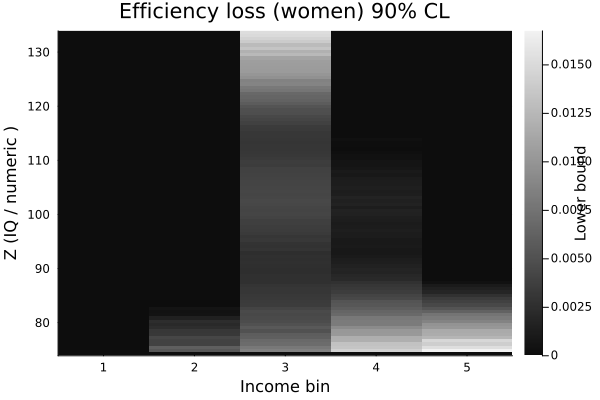

In [37]:
using Plots

p=heatmap(
    1:B, zgrid, el_women;
    xlabel = "Income bin",
    ylabel = "Z (IQ / numeric )",
    title  = "Efficiency loss (women) 90% CL",
    color  = :grays,
    clims  = (0, maximum(el_women)),
    colorbar_title = "Lower bound"
)


In [38]:
savefig(p, joinpath(export_dir, "efficiency_loss_women.png"))


"/Users/jorditorresvallverdu/Documents/GitHub/TSE-2025-2026/set_identification/efficiency_loss_women.png"

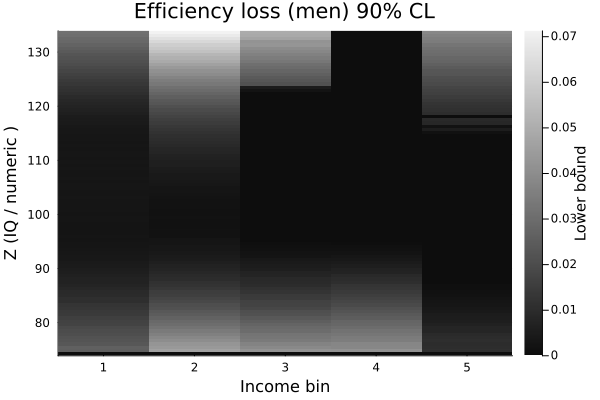

In [39]:
p=heatmap(
    1:B, zgrid, el_men;
    xlabel = "Income bin",
    ylabel = "Z (IQ / numeric )",
    title  = "Efficiency loss (men) 90% CL",
    color  = :grays,
    clims  = (0, maximum(el_men)),
    colorbar_title = "Lower bound"
)



In [40]:
savefig(p, joinpath(export_dir, "efficiency_loss_men.png"))


"/Users/jorditorresvallverdu/Documents/GitHub/TSE-2025-2026/set_identification/efficiency_loss_men.png"

**Appendix**



**Test for monothonicity of E(Y/Z=z)**
This boils down to testing whether the probability of Y=1 is increasing in Z. Usual tests include Hu, Shi (2019), Chetverikhov (2013). These tests, however, are done under much more complicated cases as in mine: Hu et al, for example, account for a setting with Y being continuous and Z also being continuous; in my case, I just need to test over Z=1,2,3...

Given that the idea is to use set identification techniques, I will provide some evidence that this holds or not for a given subset of the data. Then I will focus mostly on the el(z) measure.

In [41]:
size_subsample=10
size_p=3

m= zeros(Float64, size_subsample, size_p, size_p)

10×3×3 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [42]:
##Estimate probabilities 

function cell_probs(df, instrument::Symbol)
    zvals = sort(unique(df[!, instrument]))
    k = length(zvals)
    p_k = zeros(Float64, k)
    n_k = zeros(Int, k)

    for (i, z) in enumerate(zvals)
        num = sum((df.postsec_stem2 .== 1) .&
                  (df[!, instrument] .== z))

        n_k[i] = sum(df[!, instrument] .== z)
        p_k[i] = num / n_k[i]
    end

    return p_k, n_k
end



probs= [cell_probs(i, :z_numeric_iq) for i in subsamples]

10-element Vector{Tuple{Vector{Float64}, Vector{Int64}}}:
 ([0.26865671641791045, 0.3076923076923077, 0.2708333333333333, 0.45652173913043476, 0.358974358974359, 0.44, 0.5357142857142857], [67, 52, 48, 46, 39, 25, 28])
 ([0.5714285714285714, 0.5, 0.46875, 0.5263157894736842, 0.6341463414634146, 0.5714285714285714, 0.5806451612903226], [28, 24, 32, 38, 41, 42, 62])
 ([0.12244897959183673, 0.2, 0.2571428571428571, 0.37142857142857144, 0.25, 0.34782608695652173, 0.5], [49, 40, 35, 35, 28, 23, 20])
 ([0.6666666666666666, 0.5789473684210527, 0.6111111111111112, 0.6, 0.6666666666666666, 0.7083333333333334, 0.45], [15, 19, 18, 10, 15, 24, 20])
 ([0.2857142857142857, 0.22916666666666666, 0.28888888888888886, 0.425531914893617, 0.2777777777777778, 0.2894736842105263, 0.3333333333333333], [49, 48, 45, 47, 36, 38, 21])
 ([0.37037037037037035, 0.5789473684210527, 0.6206896551724138, 0.7333333333333333, 0.6428571428571429, 0.65625, 0.65625], [27, 19, 29, 15, 28, 32, 32])
 ([0.1875, 0.32352941176470

In [43]:
function compute_var(p_k, n_k)
    k = length(p_k)
    var = zeros(k)
    for j in 1:k
        var[j] = p_k[j] * (1 - p_k[j]) / n_k[j]
    end
    return var
end


compute_var (generic function with 1 method)

In [44]:
#Generate moment inequalities 
function monotonicity_AS(df, instrument::Symbol)

    p_k, n_k = cell_probs(df, instrument)
    var = compute_var(p_k, n_k)

    K = length(p_k)
    if K < 2
        error("Need at least 2 Z categories for monotonicity test.")
    end

    J = K - 1  #number of inequalities
    g = zeros(J)
    sig = zeros(J)

    for j in 1:J
        g[j] = p_k[j+1] - p_k[j]
        sig[j] = sqrt(var[j+1] + var[j])
    end

    n = nrow(df)
    tvals = zeros(J)
    for j in 1:J
        if sig[j] > 0
            tvals[j] = sqrt(n) * (-min(g[j], 0)) / sig[j]
        else
            tvals[j] = 0.0
        end
    end

    T = maximum(tvals)

    return g, sig, T
end


monotonicity_AS (generic function with 1 method)

In [45]:
T_vals = Float64[]
g_list = []
sig_list = []

for df_sub in subsamples
    g, sig, T = monotonicity_AS(df_sub, :z_numeric_iq)
    push!(T_vals, T)
    push!(g_list, g)
    push!(sig_list, sig)
end

T_vals ##same rejections as before

10-element Vector{Float64}:
 16.03030693200288
  9.56080823423765
 15.92825184705254
 19.61720320889689
 23.989053654684216
  8.375794608833571
 10.804590844148679
  5.7177596557059305
  2.401728746527021
 19.720571359014546

In [46]:
using Distributions
using Random

function boot_t_1(subsamples, instrument::Symbol, b_iter::Int64)

    nsubs = length(subsamples)
    T_dist = zeros(nsubs, b_iter)

    for b in 1:b_iter
        for i in 1:nsubs

            dt = subsamples[i]
            n_i = nrow(dt)

            hat_p = mean(dt.postsec_stem2)

            Y_b = rand.(Bernoulli(hat_p), n_i)

            dt_boot = deepcopy(dt)
            dt_boot.postsec_stem2 = Y_b

            _, _, T_dist[i, b] = monotonicity_AS(dt_boot, instrument)

        end
    end

    return T_dist
end


boot_t_1 (generic function with 1 method)

In [47]:
Random.seed!(12345)

T_dist = boot_t_1(subsamples, :z_numeric_iq, 1000)

# critical values
cv_95 = [quantile(T_dist[i,:], 0.95) for i in 1:length(subsamples)]
cv_90 = [quantile(T_dist[i,:], 0.90) for i in 1:length(subsamples)]
cv_85 = [quantile(T_dist[i,:], 0.85) for i in 1:length(subsamples)]


cv_85

10-element Vector{Float64}:
 34.44931552918497
 32.832748409854574
 31.361168476565915
 23.225906321566963
 34.7856204568331
 27.852989658469284
 31.044340427128034
 26.834602838980246
 32.126490950065204
 26.232057779598975

In [48]:
using DataFrames

function monot_table(subsamples, T_vals, cv_95, cv_90, cv_85)

    n = length(subsamples)

    df_out = DataFrame(
        subsample = Int[],
        income = String[],
        gender = String[],
        T_stat = Float64[],
        cv_95 = Float64[],
        cv_90 = Float64[],
        cv_85 = Float64[],
        reject_95 = Int[],
        reject_90 = Int[],
        reject_85 = Int[]
    )

    for i in 1:n

        income_i = string(unique(subsamples[i].c_sskills_income)[1])
        gender_i = string(unique(subsamples[i].c_iq_male)[1])

        T_i = T_vals[i]

        r95 = T_i >= cv_95[i] ? 1 : 0
        r90 = T_i >= cv_90[i] ? 1 : 0
        r85 = T_i >= cv_85[i] ? 1 : 0

        push!(df_out, (
            i,
            income_i,
            gender_i,
            T_i,
            cv_95[i],
            cv_90[i],
            cv_85[i],
            r95,
            r90,
            r85
        ))
    end

    return df_out
end

df = monot_table(subsamples, T_vals, cv_95, cv_90, cv_85) ##prob too strict or not the correct way to test!

Row,subsample,income,gender,T_stat,cv_95,cv_90,cv_85,reject_95,reject_90,reject_85
,Int64,String,String,Float64,Float64,Float64,Float64,Int64,Int64,Int64
1,1,1.0,0,16.0303,42.3049,37.4079,34.4493,0,0,0
2,2,1.0,1,9.56081,40.5134,36.113,32.8327,0,0,0
3,3,2.0,0,15.9283,38.5178,33.7553,31.3612,0,0,0
4,4,2.0,1,19.6172,29.2541,25.3331,23.2259,0,0,0
5,5,3.0,0,23.9891,43.7467,38.3659,34.7856,0,0,0
6,6,3.0,1,8.37579,33.6531,29.6743,27.853,0,0,0
7,7,4.0,0,10.8046,39.0969,34.2661,31.0443,0,0,0
8,8,4.0,1,5.71776,35.1585,30.9939,26.8346,0,0,0
9,9,5.0,0,2.40173,39.5413,35.0423,32.1265,0,0,0
